In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализаций
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [16]:
# 1. Загрузка данных
df = pd.read_csv('data/MSPUS.csv', parse_dates=['observation_date'], index_col='observation_date')
df.sort_index(inplace=True)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1963-01-01 to 2024-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   MSPUS   248 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB
None

Описательная статистика:
               MSPUS
count     248.000000
mean   156114.112903
std    115951.319546
min     17800.000000
25%     55900.000000
50%    128350.000000
75%    235375.000000
max    442600.000000


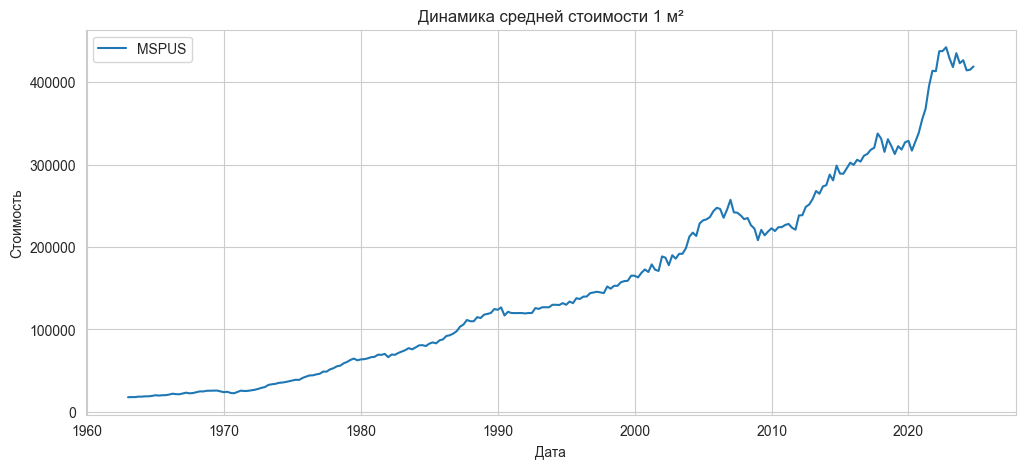

In [17]:
# 2. Исследование данных
print("Информация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

# Визуализация временного ряда
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['MSPUS'], label='MSPUS')
plt.title('Динамика средней стоимости 1 м²')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.legend()
plt.show()

In [18]:
# 3. Предварительная обработка данных
# Декомпозиция для создания трёх признаков: тренд, сезонность, остатки
decomposition = seasonal_decompose(df['MSPUS'], model='additive', period=4)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Создаем датасет для кластеризации
cluster_df = pd.DataFrame({
    'Trend': trend,
    'Seasonal': seasonal,
    'Residual': residual
})

# Удаляем строки с NaN (возникают из-за декомпозиции)
cluster_df = cluster_df.dropna()

# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# Проверка на наличие NaN
if np.isnan(scaled_data).any():
    print("Внимание: В данных для кластеризации есть NaN. Убедитесь, что декомпозиция корректна.")
    # Дополнительная обработка (например, заполнение средним)
    scaled_data = np.nan_to_num(scaled_data)

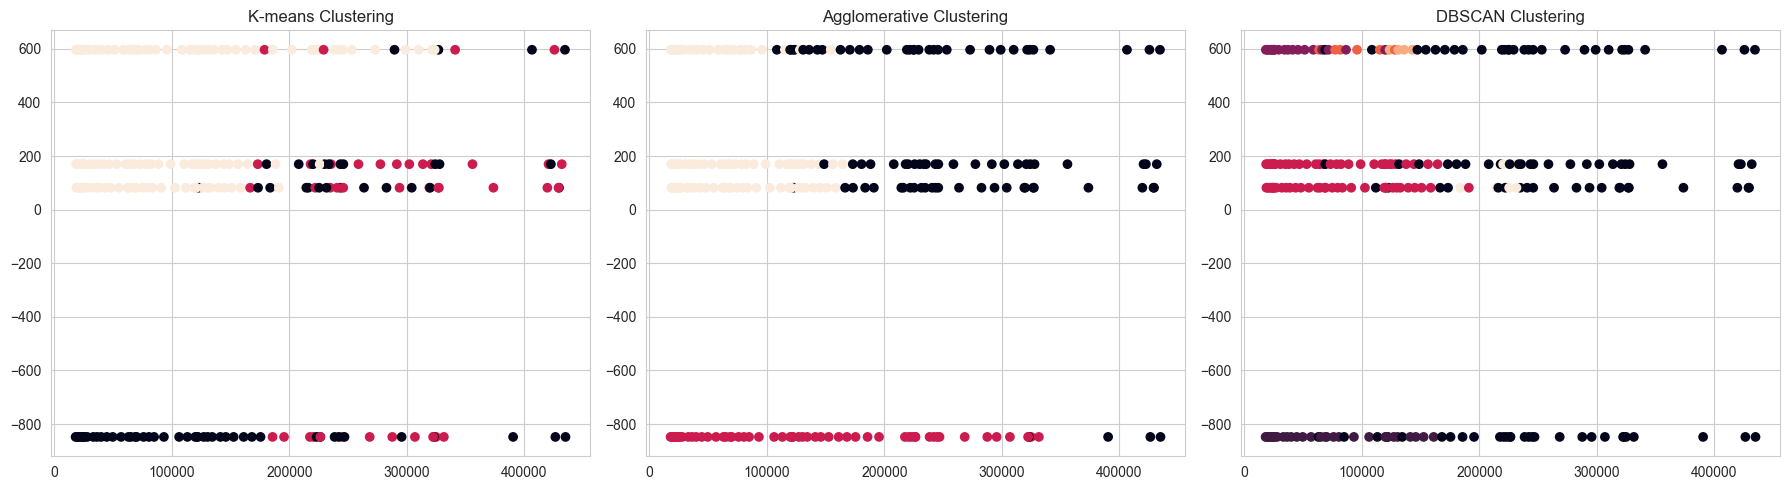

In [19]:
# 4-5. Кластеризация по трем методам
# Итеративный метод (K-means)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_data)

# Иерархический метод (Agglomerative Clustering)
agg = AgglomerativeClustering(n_clusters=3)
agg_clusters = agg.fit_predict(scaled_data)

# Плотностный метод (DBSCAN)
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Параметры подбираются экспериментально
dbscan_clusters = dbscan.fit_predict(scaled_data)

# Визуализация кластеров
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Визуализируем первые два признака (Trend и Seasonal)
axes[0].scatter(cluster_df['Trend'], cluster_df['Seasonal'], c=kmeans_clusters)
axes[0].set_title('K-means Clustering')

axes[1].scatter(cluster_df['Trend'], cluster_df['Seasonal'], c=agg_clusters)
axes[1].set_title('Agglomerative Clustering')

axes[2].scatter(cluster_df['Trend'], cluster_df['Seasonal'], c=dbscan_clusters)
axes[2].set_title('DBSCAN Clustering')

plt.tight_layout()
plt.show()

In [20]:
# 6-7. Прогнозирование стоимости (временные ряды)
# Разделение данных на train/test (80/20)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Методы: SARIMA и Prophet
# Метрики: RMSE и MAE (обоснованы чувствительностью к ошибкам)

# Функция оценки SARIMA
def evaluate_sarima(train, test, order, seasonal_order):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# Параметры для SARIMA (примеры)
sarima_params = [
    ( (2,1,1), (1,1,1,4) ),  # Пример 1
    ( (1,1,2), (2,1,1,4) )   # Пример 2
]

# Функция оценки Prophet
def evaluate_prophet(train, test):
    df_train = train.reset_index().rename(columns={'observation_date': 'ds', 'MSPUS': 'y'})
    model = Prophet()
    model.fit(df_train)
    future = model.make_future_dataframe(periods=len(test), freq='Q')
    forecast = model.predict(future)
    return forecast.iloc[-len(test):]['yhat']

# Оценка моделей
best_rmse = float('inf')
best_forecast = None

# Оценка SARIMA
for order, seasonal_order in sarima_params:
    forecast = evaluate_sarima(train['MSPUS'], test['MSPUS'], order, seasonal_order)
    rmse = np.sqrt(mean_squared_error(test['MSPUS'], forecast))
    print(f"SARIMA{order}{seasonal_order} RMSE: {rmse:.2f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_forecast = forecast

# Оценка Prophet
forecast_prophet = evaluate_prophet(train, test)
rmse_p = np.sqrt(mean_squared_error(test['MSPUS'], forecast_prophet))
print(f"Prophet RMSE: {rmse_p:.2f}")

SARIMA(2, 1, 1)(1, 1, 1, 4) RMSE: 80714.81
SARIMA(1, 1, 2)(2, 1, 1, 4) RMSE: 75843.27


20:11:26 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 60172.51


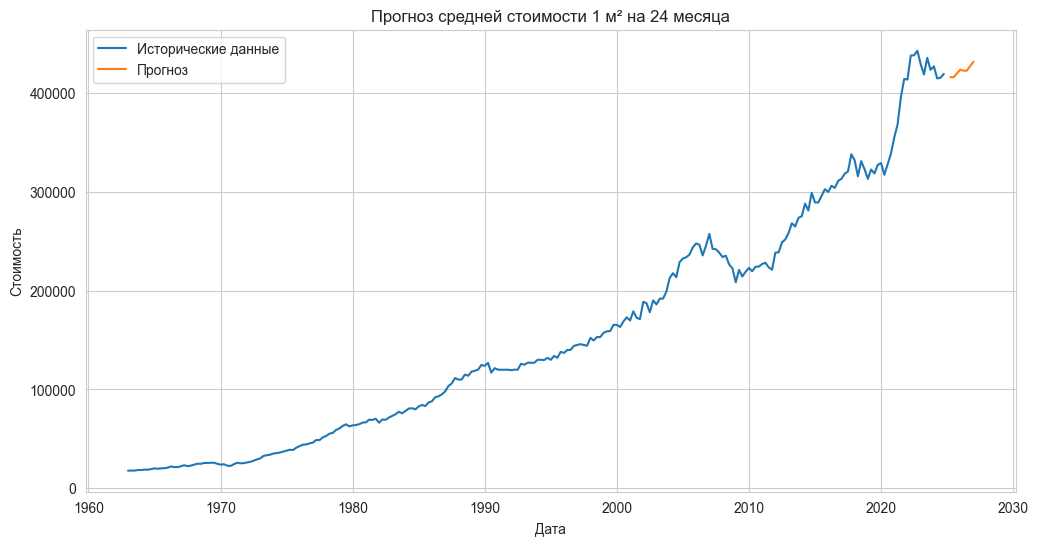

In [21]:
# 8. Прогнозирование на 24 месяца (8 кварталов)
# Выбираем лучшую модель (например, SARIMA с наилучшими параметрами)
best_order = (2,1,1)
best_seasonal = (1,1,1,4)

model = SARIMAX(df['MSPUS'], order=best_order, seasonal_order=best_seasonal)
model_fit = model.fit(disp=False)
forecast = model_fit.forecast(steps=8)  # 8 кварталов = 24 месяца

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MSPUS'], label='Исторические данные')
plt.plot(pd.date_range(df.index[-1], periods=9, freq='Q')[1:], forecast, label='Прогноз')
plt.title('Прогноз средней стоимости 1 м² на 24 месяца')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.legend()
plt.show()